# Loan Default Prediction

- We tried a little different methods of data engineering, but because of the differences between the datas we are not sure if they had a better results or not, but with the same model (logistic regression with GridSearchCV) it had slightly higher accuracy score (83.80%).
- We used newer ml models that came after 2014. These hat significantly higher accuracy scores:
    - XGBoost (88.86%)
    - LightGBM (88.96%)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc, RocCurveDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

New data is imported. It has data from 01.06.2007 to 01.12.2016

In [2]:
data = pd.read_csv('lending_club_loan_two.csv')
data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


# Data Cleaning

Fix Date-Time

In [3]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

C:\Users\Seawolf\AppData\Local\Temp\ipykernel_21812\836848778.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])
C:\Users\Seawolf\AppData\Local\Temp\ipykernel_21812\836848778.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


Remove or Conver Outliers

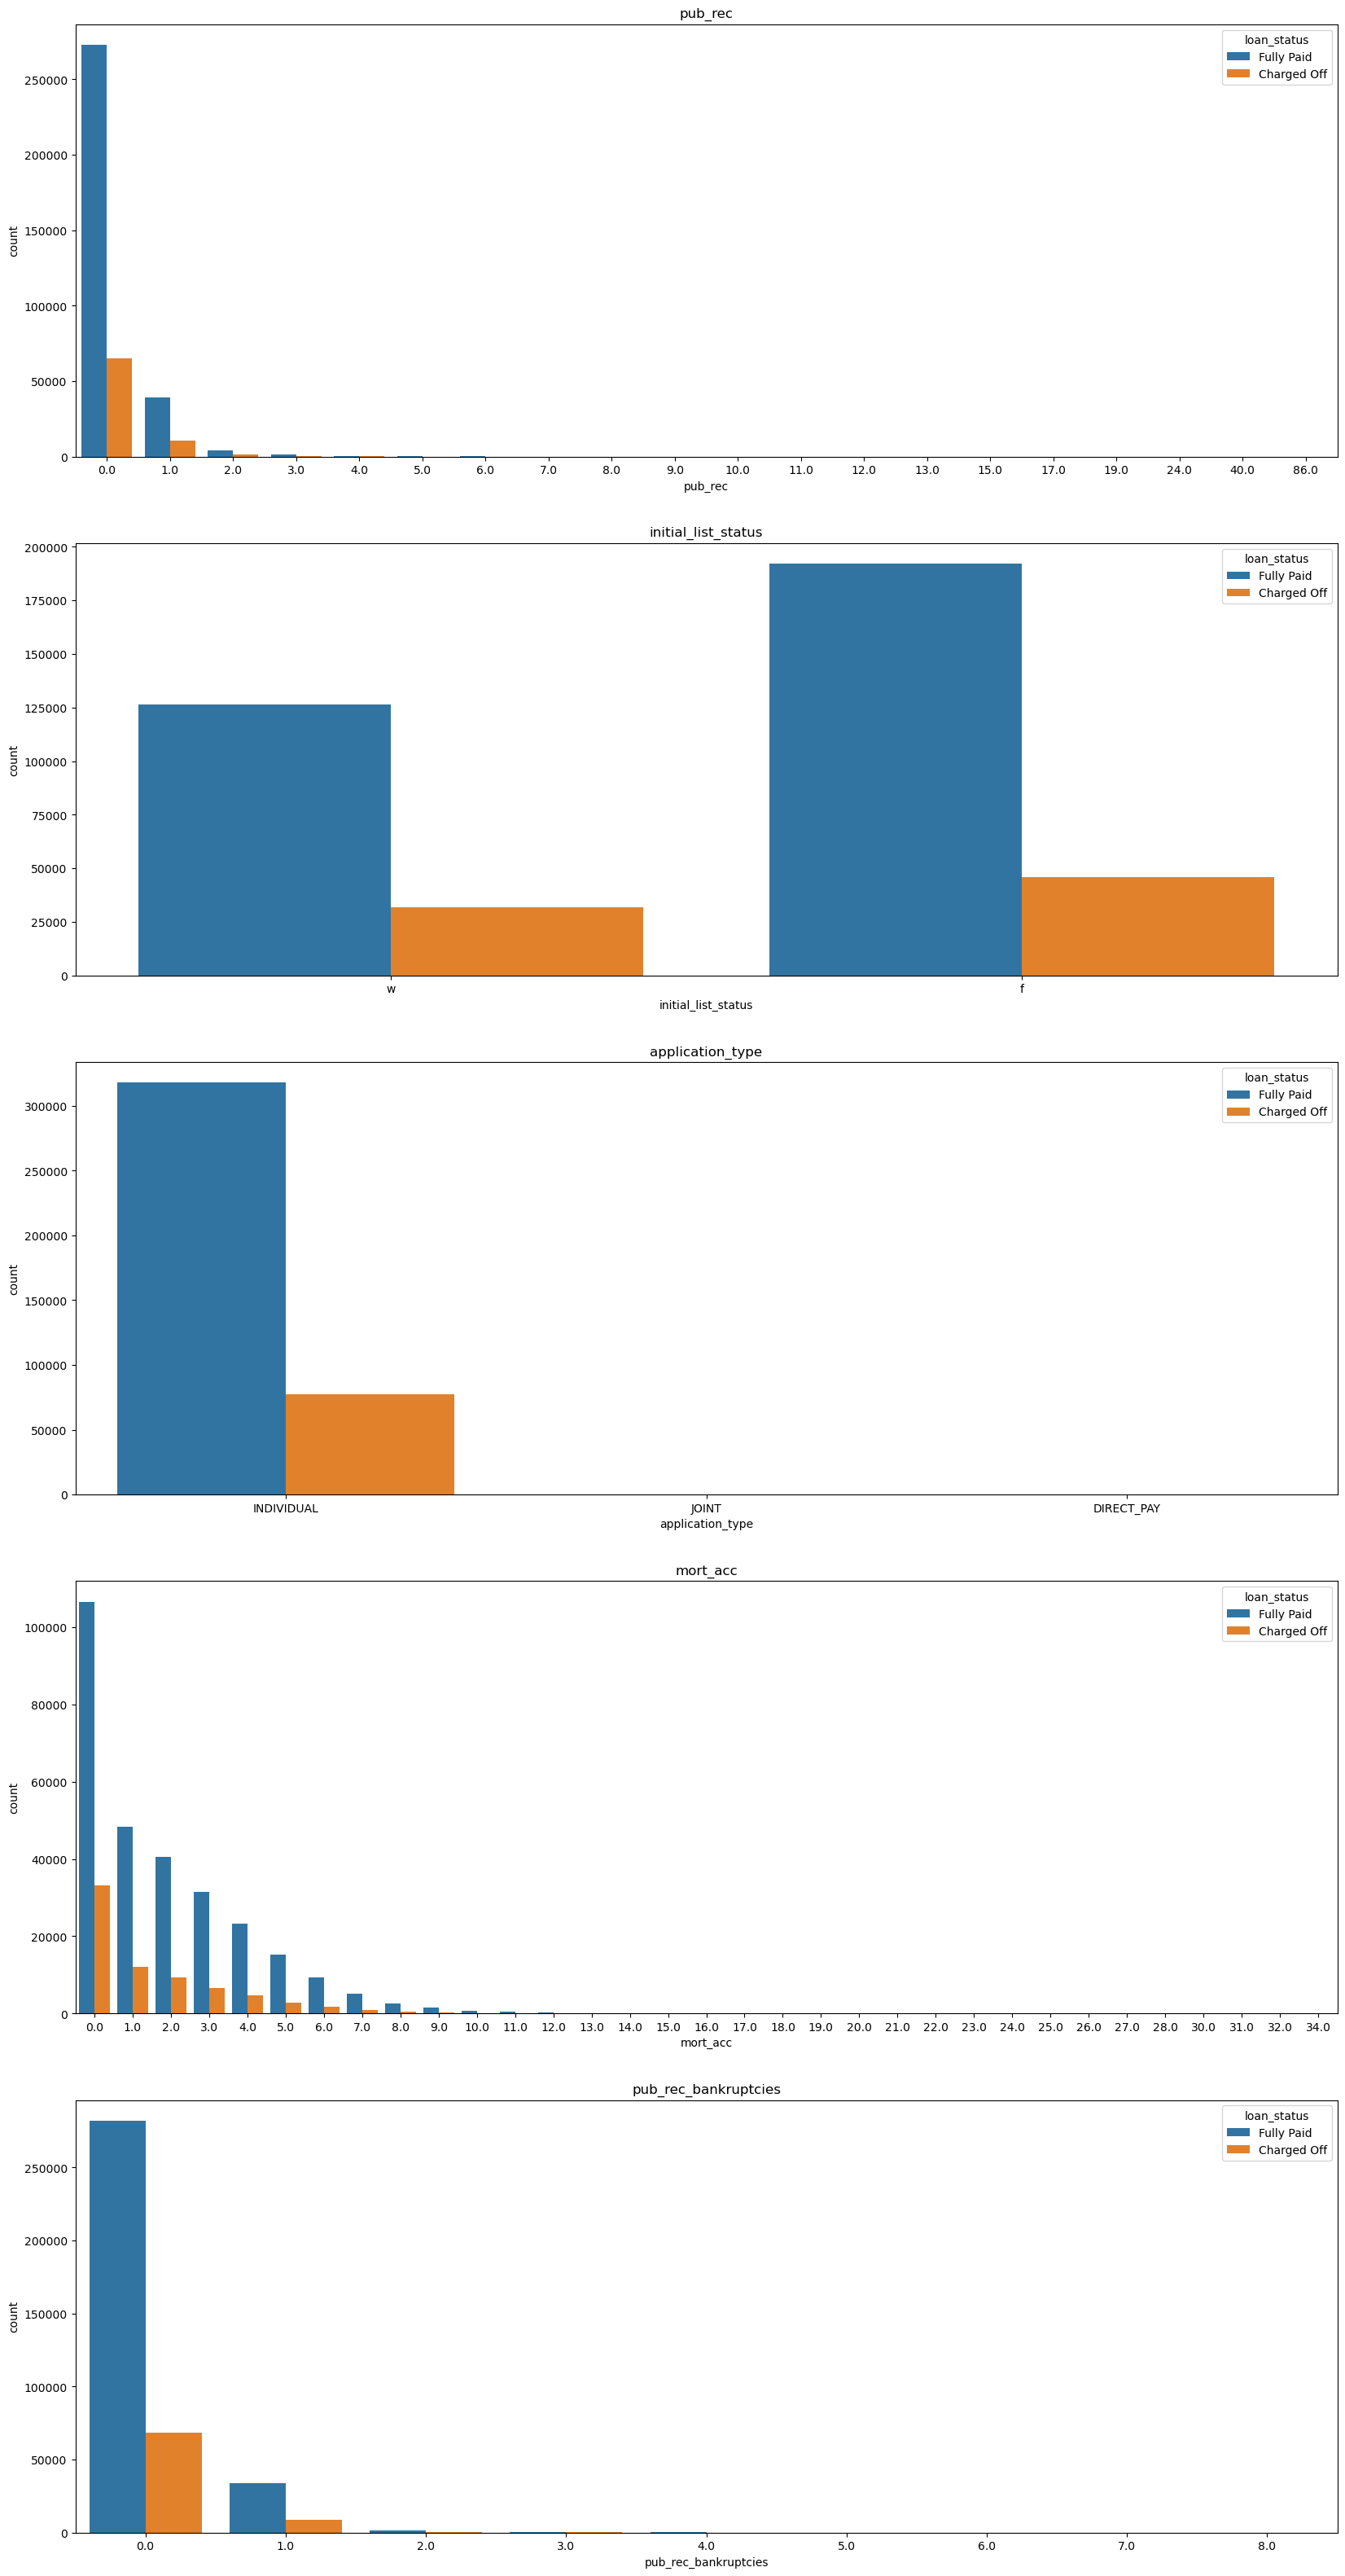

In [4]:
# Check for loan status according to pub_rec, initial_list_status, application_type, mort_acc, pub_rec_bankruptcies with seperate plots in one column
cols = ['pub_rec', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']
plt.figure(figsize=(20, 40))
for i, col in enumerate(cols):
    plt.subplot(5, 1, i+1)
    sns.countplot(x=col, hue='loan_status', data=data)
    plt.title(col)
plt.show()

Most of the values of pub_rec and pub_rec_bankruptcies 0 or 1, we can convert the other values to simplify the data

In [5]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)
data['mort_acc'] = data.mort_acc.apply(mort_acc)

#### Drop duplicate columns

In [6]:
# 'title' column is a subcategory/description of the 'purpose' column. So we can drop this column
data.drop('title', axis=1, inplace=True)

# 'grade' is just a sub feature of 'sub_grade', So we are goinig to drop it.
data.drop('grade', axis=1, inplace=True)

### NaN Values

In [7]:
# check vor NaN values in the dataset show it as a percent of that column
def check_for_nan(data):
    nan_columns = []
    for column in data.columns:
        if data[column].isnull().sum() > 0:
            nan_columns.append(column)
    return nan_columns

nan_columns = check_for_nan(data)
print("Columns with NaN values: ", nan_columns)
print("Percent of NaN values in each column: ")
for column in nan_columns:
    print(column, ":", round(data[column].isnull().sum() / len(data[column]) * 100, 2), "%")

Columns with NaN values:  ['emp_title', 'emp_length', 'revol_util', 'mort_acc', 'pub_rec_bankruptcies']
Percent of NaN values in each column: 
emp_title : 5.79 %
emp_length : 4.62 %
revol_util : 0.07 %
mort_acc : 9.54 %
pub_rec_bankruptcies : 0.14 %


#### emp_title

In [8]:
data.emp_title.nunique()

173105

In [9]:
# Realistically there are too many unique job titles to try to convert this to a dummy variable feature.
data.drop('emp_title', axis=1, inplace=True)

#### emp_length

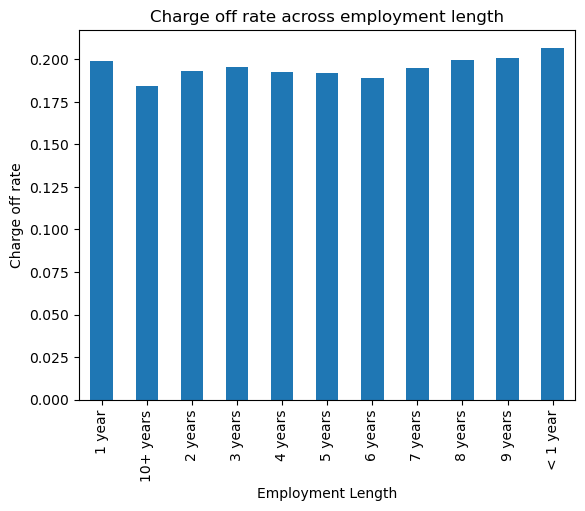

In [10]:
# Check for charge off rates across all the employment length
emp_length = data['emp_length'].value_counts().sort_index()
emp_co = data[data['loan_status'] == 'Charged Off']['emp_length'].value_counts().sort_index()
emp_fp = data[data['loan_status'] == 'Fully Paid']['emp_length'].value_counts().sort_index()
emp_len = emp_co / emp_length
emp_len.plot(kind='bar')
plt.title('Charge off rate across employment length')
plt.xlabel('Employment Length')
plt.ylabel('Charge off rate')
plt.show()

In [11]:
# Charged off rates are similar accross all the employment length. So we can drop this column
data.drop('emp_length', axis=1, inplace=True)

#### mort_acc

In [12]:
data.mort_acc.value_counts()

mort_acc
1.00    218458
0.00    139777
Name: count, dtype: int64

<Axes: >

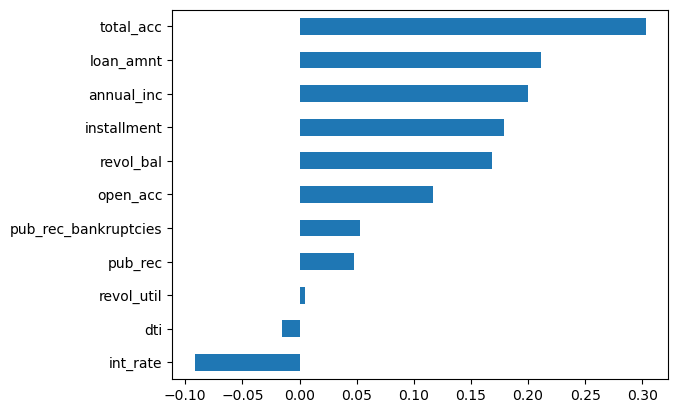

In [13]:
# Find the correlation mort_acc and the other numeric variables as horizontal bar plots
data.corr(numeric_only = True)['mort_acc'].sort_values().drop('mort_acc').plot(kind='barh')

In [14]:
total_acc_avg = data.groupby(['total_acc']).mean(numeric_only = True).mort_acc

def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

In [15]:
data.mort_acc.value_counts()

mort_acc
1.00    242794
0.00    153236
Name: count, dtype: int64

#### revol_util & pub_rec_bankruptcies

These two features have missing data points, but they account for less than 0.5% of the total data. So we are going to remove the rows that are missing those values in those columns with dropna().

In [16]:
data.dropna(inplace=True)

### Categorical Variables and Dummy Variables

In [17]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'sub_grade', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'initial_list_status', 'application_type', 'address']


In [18]:
# Convert the term feature into either a 36 or 60 integer numeric data type using .apply().
data['term'] = data['term'].apply(lambda term: int(term[:3]))

In [19]:
# Get zipcode from address column
data['zipcode'] = data['address'].apply(lambda address: address[-5:])
# Drop address column
data.drop('address', axis=1, inplace=True)

It seems 'issue_d' would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [20]:
data.drop('issue_d', axis=1, inplace=True)

In [21]:
# Get only year value from earliest_cr_line column
data['earliest_cr_line'] = data['earliest_cr_line'].apply(lambda date: date.year)

In [22]:
data.head()

,loan_amnt,term,int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,zipcode
0,10000.00,36,11.44,329.48,B4,RENT,117000.00,Not Verified,Fully Paid,vacation,26.24,1990,16.00,0,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,22690
1,8000.00,36,11.99,265.68,B5,MORTGAGE,65000.00,Not Verified,Fully Paid,debt_consolidation,22.05,2004,17.00,0,20131.00,53.30,27.00,f,INDIVIDUAL,1.00,0.00,05113
2,15600.00,36,10.49,506.97,B3,RENT,43057.00,Source Verified,Fully Paid,credit_card,12.79,2007,13.00,0,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,05113
3,7200.00,36,6.49,220.65,A2,RENT,54000.00,Not Verified,Fully Paid,credit_card,2.60,2006,6.00,0,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,00813
4,24375.00,60,17.27,609.33,C5,MORTGAGE,55000.00,Verified,Charged Off,credit_card,33.95,1999,13.00,0,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,11650


In [23]:
data['pub_rec'].value_counts()

pub_rec
0    337489
1     57730
Name: count, dtype: int64

#### Convert rest of the object variables into dummy variables

In [24]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

In [25]:
# Convert loan_status column into 0s and 1s
# Fully Paid = 1, Charged Off = 0

data['loan_status'] = data['loan_status'].apply(lambda status: 1 if status == 'Fully Paid' else 0)

### Train-Test Split

In [26]:
train, test = train_test_split(data, test_size=0.33, random_state=42)

print(train.shape)
print(test.shape)

(264796, 73)
(130423, 73)


#### Remove the Outliers

In [27]:
train = train[train['annual_inc'] <= 250000]
train = train[train['dti'] <= 50]
train = train[train['open_acc'] <= 40]
train = train[train['total_acc'] <= 80]
train = train[train['revol_util'] <= 120]
train = train[train['revol_bal'] <= 250000]

#### Normalizing the data

In [28]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

In [29]:
data.head()

,loan_amnt,term,int_rate,installment,annual_inc,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zipcode,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,...,sub_grade_G4,sub_grade_G5,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10000.00,36,11.44,329.48,117000.00,1,26.24,1990,16.00,0,36369.00,41.80,25.00,0.00,0.00,22690,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,False,False,True
1,8000.00,36,11.99,265.68,65000.00,1,22.05,2004,17.00,0,20131.00,53.30,27.00,1.00,0.00,05113,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False
2,15600.00,36,10.49,506.97,43057.00,1,12.79,2007,13.00,0,11987.00,92.20,26.00,0.00,0.00,05113,False,False,False,False,False,False,True,False,False,...,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,7200.00,36,6.49,220.65,54000.00,1,2.60,2006,6.00,0,5472.00,21.50,13.00,0.00,0.00,00813,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
4,24375.00,60,17.27,609.33,55000.00,0,33.95,1999,13.00,0,24584.00,69.80,43.00,1.00,0.00,11650,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False


In [30]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)

## Model Building


#### Score Builder

In [31]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

#### Logistic Regression with GridSearchCV

In [34]:
# Logistic Regression with GridSearchCV
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

clf = GridSearchCV(log_reg, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train)

print(f"Best Score: {best_clf.best_score_ * 100:.2f}%")
print("_____________________________________")
print(f"Best Parameters: {best_clf.best_params_}")
print("_____________________________________")

y_pred = best_clf.predict(X_train)
y_test_pred = best_clf.predict(X_test)

print_score(y_train, y_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


c:\Users\Seawolf\anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
70 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Seawolf\anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Seawolf\anaconda3\envs\kaggle\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Seawolf\anaconda3\envs\kaggle\lib\site-packages\sklearn\linear_model\_logistic.py", line 1168, in fit
    sol

Best Score: 83.67%
_____________________________________
Best Parameters: {'C': 0.1, 'penalty': 'l2'}
_____________________________________
Train Result:
Accuracy Score: 83.68%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.69      0.85      0.84       0.77          0.82
recall        0.31      0.97      0.84       0.64          0.84
f1-score      0.43      0.90      0.84       0.67          0.81
support   51665.00 210478.00      0.84  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 15909  35756]
 [  7029 203449]]

Test Result:
Accuracy Score: 83.80%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.69      0.85      0.84       0.77          0.82
recall        0.31      0.97      0.84       0.64          0.84
f1-score      0.42      0.91 

### XGBoost

In [38]:
# Xgb model parameters
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'random_state':42
}

# XGB CLASSIFIER
xgb_clf = XGBClassifier(**xgb_parms)

# TRAIN XGB CLASSIFIER
xgb_clf.fit(X_train, y_train)

# XGB PREDICTIONS
y_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# XGB CLASSIFIER RESULTS
print_score(y_train, y_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 88.76%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      0.88      0.89       0.94          0.90
recall        0.43      1.00      0.89       0.72          0.89
f1-score      0.60      0.93      0.89       0.77          0.87
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 22219  29446]
 [    12 210466]]

Test Result:
Accuracy Score: 88.86%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     1.00      0.88      0.89       0.94          0.90
recall        0.43      1.00      0.89       0.72          0.89
f1-score      0.60      0.94      0.89       0.77          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_________________________________________

#### LightGBM

In [39]:
import lightgbm as lgb

# LGBM CLASSIFIER
lgb_clf = lgb.LGBMClassifier()

# TRAIN LGBM CLASSIFIER
lgb_clf.fit(X_train, y_train)

# LGBM PREDICTIONS
y_pred = lgb_clf.predict(X_train)
y_test_pred = lgb_clf.predict(X_test)

# LGBM CLASSIFIER RESULTS
print_score(y_train, y_pred, train=True)
print_score(y_test, y_test_pred, train=False)


Train Result:
Accuracy Score: 89.13%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.95      0.88      0.89       0.92          0.90
recall        0.47      0.99      0.89       0.73          0.89
f1-score      0.63      0.94      0.89       0.78          0.88
support   51665.00 210478.00      0.89  262143.00     262143.00
_______________________________________________
Confusion Matrix: 
 [[ 24443  27222]
 [  1265 209213]]

Test Result:
Accuracy Score: 88.96%
_______________________________________________
CLASSIFICATION REPORT:
               0.0       1.0  accuracy  macro avg  weighted avg
precision     0.94      0.88      0.89       0.91          0.89
recall        0.47      0.99      0.89       0.73          0.89
f1-score      0.62      0.94      0.89       0.78          0.87
support   25480.00 104943.00      0.89  130423.00     130423.00
_________________________________________